In [1]:
import gzip
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy
import string
import random
from random import sample
import string
from sklearn import linear_model
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def readGz(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)

In [4]:
answers = {}

In [5]:
# Some data structures that will be useful

In [46]:
import pandas as pd
import gzip
import json 

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')
df = getDF('Prime_Pantry_5.json.gz')





# Part 1: Identifying a Dataset and Exploratory Analysis

The data set have decided to work with is the Amazon review dataset in 2018. Specifically we are looking at a subset of the data which follows a 5-cores model such that each of the remaining users and items have 5 reviews each. The specific genre of reviews we are using for the 5-cores amazon data is the prime pantry data which consists of 137,778 data records.

In [47]:
df


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style
0,4.0,True,"09 24, 2015",A31Y9ELLA1JUB0,B0000DIWNI,Her Royal Peepness Princess HoneyBunny Blayze,I purchased this Saran premium plastic wrap af...,Pretty Good For plastic Wrap,1443052800,NaN,NaN,NaN
1,5.0,True,"06 23, 2015",A2FYW9VZ0AMXKY,B0000DIWNI,Mary,I am an avid cook and baker. Saran Premium Pl...,"The Best Plastic Wrap for your Cooking, Baking...",1435017600,NaN,NaN,NaN
2,5.0,True,"06 13, 2015",A1NE43T0OM6NNX,B0000DIWNI,Tulay C,"Good wrap, keeping it in the fridge makes it e...",Good and strong.,1434153600,NaN,NaN,NaN
3,4.0,True,"06 3, 2015",AHTCPGK2CNPKU,B0000DIWNI,OmaShops,I prefer Saran wrap over other brands. It does...,Doesn't cling as well to dishes as other brand...,1433289600,NaN,NaN,NaN
4,5.0,True,"04 20, 2015",A25SIBTMVXLB59,B0000DIWNI,Nitemanslim,Thanks,Five Stars,1429488000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
137783,5.0,True,"02 2, 2018",A2P38K4LK09134,B01HI76790,Amazon Customer,great,Five Stars,1517529600,NaN,NaN,NaN
137784,4.0,True,"11 30, 2017",AE4FU8QRB3KXA,B01HI76XS0,J,These are delicious and healthy snacks! I wit...,I purchased these because they're lower in sug...,1512000000,NaN,NaN,NaN
137785,5.0,True,"09 17, 2017",A36MOFABIPIPGM,B01HI76XS0,Love to Cook,Taste not to be believed. Buy a box for my off...,Five Stars,1505606400,NaN,NaN,NaN
137786,5.0,True,"01 31, 2018",A1TKNVUVJ8I8KW,B01HI76SA8,Jacci Washington,They are yummy!,Best healthy snack ever!,1517356800,NaN,NaN,NaN


Looking at our pandas data table above created from the amazon dataset we can see there are 12 different columns. We will be dropping columns ['vote','image','style'] due to all entries of those columns being NaN entires.  

In [48]:
df = df.drop(columns = ['vote', 'image', 'style'])
df

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime
0,4.0,True,"09 24, 2015",A31Y9ELLA1JUB0,B0000DIWNI,Her Royal Peepness Princess HoneyBunny Blayze,I purchased this Saran premium plastic wrap af...,Pretty Good For plastic Wrap,1443052800
1,5.0,True,"06 23, 2015",A2FYW9VZ0AMXKY,B0000DIWNI,Mary,I am an avid cook and baker. Saran Premium Pl...,"The Best Plastic Wrap for your Cooking, Baking...",1435017600
2,5.0,True,"06 13, 2015",A1NE43T0OM6NNX,B0000DIWNI,Tulay C,"Good wrap, keeping it in the fridge makes it e...",Good and strong.,1434153600
3,4.0,True,"06 3, 2015",AHTCPGK2CNPKU,B0000DIWNI,OmaShops,I prefer Saran wrap over other brands. It does...,Doesn't cling as well to dishes as other brand...,1433289600
4,5.0,True,"04 20, 2015",A25SIBTMVXLB59,B0000DIWNI,Nitemanslim,Thanks,Five Stars,1429488000
...,...,...,...,...,...,...,...,...,...
137783,5.0,True,"02 2, 2018",A2P38K4LK09134,B01HI76790,Amazon Customer,great,Five Stars,1517529600
137784,4.0,True,"11 30, 2017",AE4FU8QRB3KXA,B01HI76XS0,J,These are delicious and healthy snacks! I wit...,I purchased these because they're lower in sug...,1512000000
137785,5.0,True,"09 17, 2017",A36MOFABIPIPGM,B01HI76XS0,Love to Cook,Taste not to be believed. Buy a box for my off...,Five Stars,1505606400
137786,5.0,True,"01 31, 2018",A1TKNVUVJ8I8KW,B01HI76SA8,Jacci Washington,They are yummy!,Best healthy snack ever!,1517356800


After dropping columns ['vote', 'image', 'style'] we now are left with 9 columns. There are two columns which determine the date/time when a review was written which we want to explore. ['reviewTime'] which represents the date as (d/mm/yy) and ['unixReviewTime'] which respresents the date in unix time - which is easier to interact and explore with in python.

One of the questions we are interested in exploring is how users rated products based on the specific day of the week. In order to analyze by the day of the week, we needed to create a new variable/column corresponding to which day of the week a review was written. We use the ['unixReviewTime'] column in order to extract the day of the week as a integer from unix time using the datetime package. We then convert the integer day of the week value to a string value ie. Sunday, Monday etc.

In [53]:
#make list stating which day of the week a review was made
from datetime import datetime
dayWeek = []
dayName = []
convertDay = {6: 'Sunday', 0:'Monday', 1:'Tuesday', 2:'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday'}
for i in df['unixReviewTime']:
    dt = datetime.fromtimestamp(i).weekday()
    dayName.append(convertDay[dt])
    dayWeek.append(dt)

#make new column stating which day of the week it is when the review was made
df['dayOfWeek'] = dayWeek
df['dayOfWeekName'] = dayName
df[['dayOfWeek', 'dayOfWeekName']]

,dayOfWeek,dayOfWeekName
0,3,Thursday
1,1,Tuesday
2,5,Saturday
3,2,Wednesday
4,0,Monday
...,...,...
137783,4,Friday
137784,3,Thursday
137785,6,Sunday
137786,2,Wednesday


We then were able to create two new columns in our dataframe. ['dayOfWeek'] which represents the day of the week as a integer when a review was written. ['dayOfWeekName'] 

In [10]:
#getting the sums of ratings by each specific day
ratingSums = df.groupby(['dayOfWeekName'])['overall'].sum()
all_sums = pd.DataFrame({'Day': list(ratingSums.keys()), 
                              'Sum': list(ratingSums)})

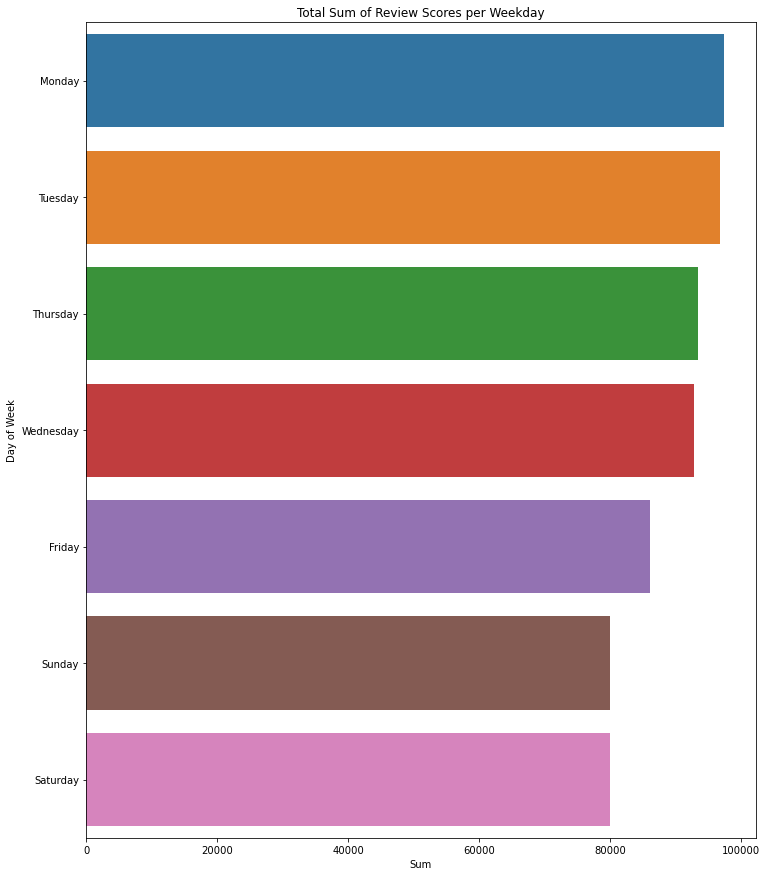

In [11]:

g = all_sums.nlargest(columns="Sum", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Sum", y = "Day") 
ax.set(ylabel = 'Day of Week', title = "Total Sum of Review Scores per Weekday") 
plt.show()

In [37]:
ratingAverage = df.groupby(['dayOfWeekName'])['overall'].mean()
all_averages = pd.DataFrame({'Day': list(ratingAverage.keys()), 
                              'Average': list(ratingAverage)})
all_averages

,Day,Average
0,Friday,4.540515
1,Monday,4.565552
2,Saturday,4.535020
3,Sunday,4.540789
4,Thursday,4.549026
5,Tuesday,4.554457
6,Wednesday,4.534352


In [31]:

all_ratings = nltk.FreqDist(df['overall']) 
ratings = []

#Converting scores 1-5 to strings for plot labels
for i in list(all_genres.keys()):
    ratings.append(str(i))
# create dataframe for ratings count in dataset
all_ratings_df = pd.DataFrame({'overall': (ratings), 
                              'Count': list(all_genres.values())})
all_ratings_df

,overall,Count
0,4.0,20308
1,5.0,101456
2,3.0,9109
3,2.0,3661
4,1.0,3254


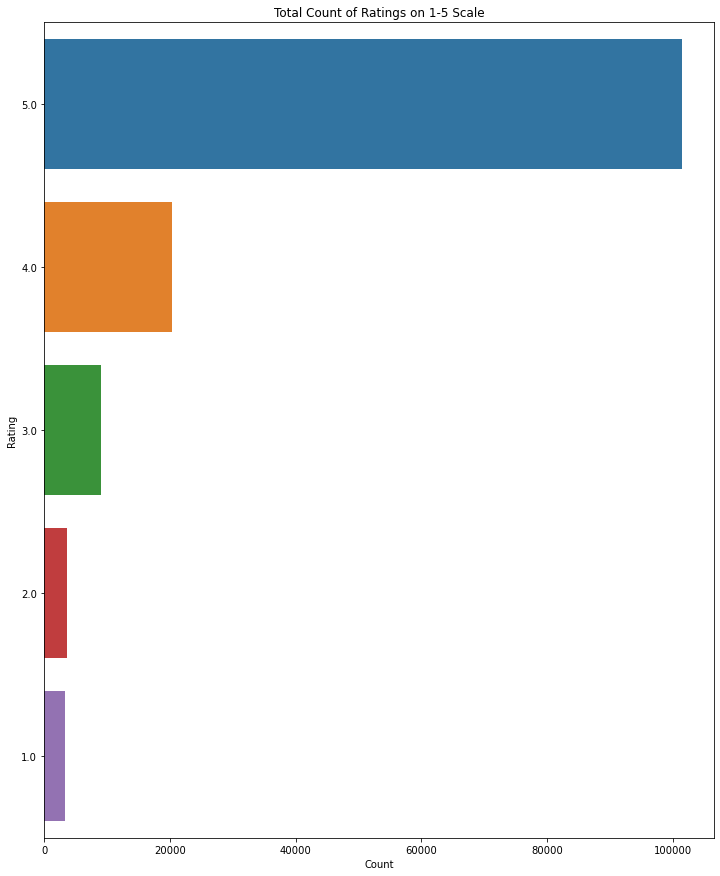

In [38]:

g = all_ratings_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "overall") 
ax.set(ylabel = 'Rating', title = "Total Count of Ratings on 1-5 Scale") 
plt.show()

In [39]:

days_count = nltk.FreqDist(dayName) 

# create dataframe to show count of reviews that took place on specific weekdays
days_count_df = pd.DataFrame({'Day': list(days_count.keys()), 
                              'Count': list(days_count.values())})

In [40]:
days_count_df

,Day,Count
0,Thursday,20540
1,Tuesday,21246
2,Saturday,17633
3,Wednesday,20479
4,Monday,21319
5,Sunday,17615
6,Friday,18956


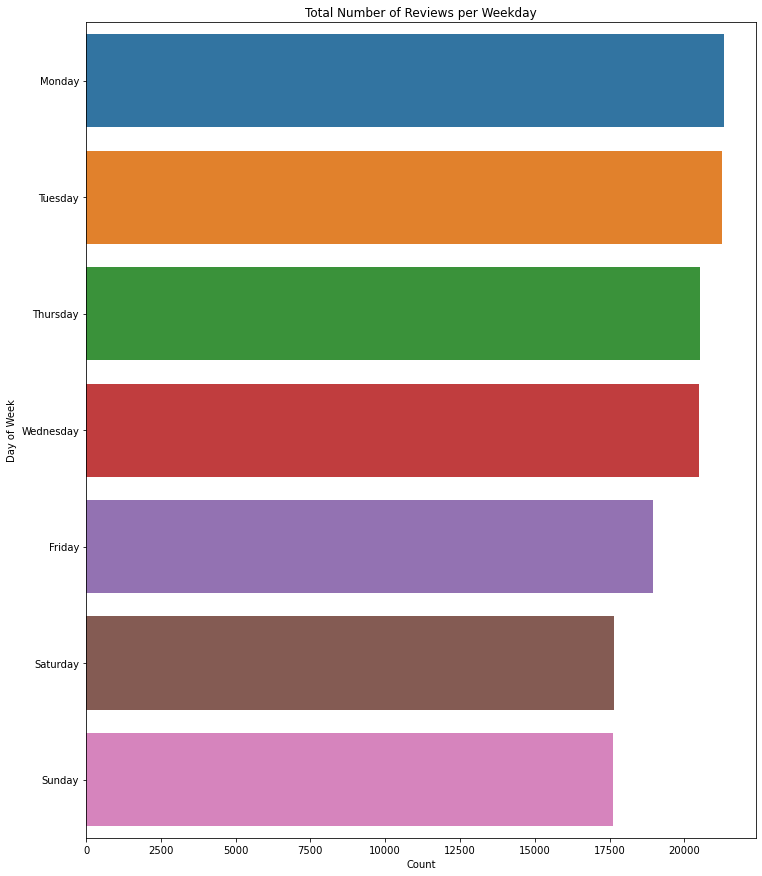

In [41]:

g = days_count_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Day") 
ax.set(ylabel = 'Day of Week', title = "Total Number of Reviews per Weekday") 
plt.show()

In [15]:
len(df)

137788

In [179]:
ratingsTrain = allRatings[:198000]
ratingsValid = allRatings[198000:]
ratingsPerUser = defaultdict(list)
ratingsPerItem = defaultdict(list)
for u,b,r in ratingsTrain:
    ratingsPerUser[u].append((b,r))
    ratingsPerItem[b].append((u,r))

In [180]:
##################################################
# Read prediction                                #
##################################################

In [193]:
#creating a new return2 set to find around the top 30% percentile of items by dividing totalRead by 1.39

bookCount = defaultdict(int)
totalRead = 0

for user,book,_ in readCSV("train_Interactions.csv.gz"):
    bookCount[book] += 1
    totalRead += 1

mostPopular = [(bookCount[x], x) for x in bookCount]
mostPopular.sort()
mostPopular.reverse()

return2 = set()
count = 0
for ic, i in mostPopular:
    count += ic
    return2.add(i)
    if count > totalRead/1.39: break
return2

{'b75920771',
 'b26354292',
 'b85255296',
 'b13716034',
 'b37807365',
 'b29520915',
 'b39941601',
 'b89141222',
 'b22227603',
 'b60613242',
 'b87612334',
 'b97218983',
 'b79116544',
 'b67474210',
 'b77265663',
 'b59555104',
 'b71294015',
 'b84770627',
 'b49991872',
 'b39501581',
 'b17741315',
 'b57862088',
 'b95081671',
 'b23457095',
 'b35765595',
 'b58888536',
 'b07533988',
 'b97371893',
 'b92040053',
 'b87393947',
 'b92071779',
 'b68095955',
 'b68325129',
 'b92099621',
 'b34532932',
 'b53252526',
 'b19956230',
 'b14574218',
 'b89251739',
 'b88947899',
 'b22016281',
 'b92457365',
 'b14109776',
 'b77544650',
 'b39738718',
 'b17906067',
 'b56662995',
 'b76932568',
 'b63993683',
 'b82203807',
 'b48132407',
 'b34969157',
 'b75706553',
 'b84319928',
 'b69089192',
 'b78156277',
 'b33846906',
 'b12288445',
 'b42027204',
 'b43914262',
 'b23089015',
 'b88949884',
 'b89024434',
 'b94263614',
 'b62396194',
 'b36231626',
 'b43699450',
 'b66348359',
 'b96064020',
 'b96621963',
 'b79124168',
 'b684

In [190]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))

    if denom == 0:
        return 0

    return numer / denom

In [192]:
#utilized a combination of my hw3 solution and Professor's hw3 solution
#tested different thresholds for maxSim, lenght of ratings per item and quartile percentage for popularity book set
predictions = open("predictions_Read.csv", 'w')
for l in open("pairs_Read.csv"):
    if l.startswith("userID"):
        predictions.write(l)
        continue
    u,b = l.strip().split(',')
    maxSim = 0
    users = set(ratingsPerItem[b])
    for b2,_ in ratingsPerUser[u]:
        sim = Jaccard(users,set(ratingsPerItem[b2]))
        if sim > maxSim:
            maxSim = sim
    pred = 0
    
    if maxSim > 0.014 or len(ratingsPerItem[b]) > 42 or b in return2:
        pred = 1
    _ = predictions.write(u + ',' + b + ',' + str(pred) + '\n')

predictions.close()

In [41]:
##################################################
# Category prediction (CSE158 only)              #
##################################################

In [156]:
data = []

for d in readGz("train_Category.json.gz"):
    data.append(d)

In [194]:
#The below prediction model was formulated in reference to a Classifier in academic journal at https://www.analyticsvidhya.com/blog/2019/04/predicting-movie-genres-nlp-multi-label-classification/

In [158]:
data[0]

{'user_id': 'u75242413',
 'review_id': 'r45843137',
 'rating': 4,
 'review_text': "a clever book with a deeply troubling premise and an intriguing protagonist. Thompson's clean, sparse prose style kept each page feeling light even as some rather heavy existential questions dropped upon them. I enjoyed it. \n and that cover design is boom-pow gorgeous.",
 'n_votes': 1,
 'genre': 'mystery_thriller_crime',
 'genreID': 3}

In [159]:
# Removing punctuation from review text
stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = re.sub("\'", "", text) 
    text = re.sub("[^a-zA-Z]"," ",text) 
    text = ' '.join(text.split()) 
    text = text.lower() 
    return text
newwords = [clean_text(x['review_text']) for x in data]


In [160]:
#cleaning review text to remove filler words
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

newwords = [clean_text(x['review_text']) for x in data]



In [161]:
newwords

['a clever book with a deeply troubling premise and an intriguing protagonist thompsons clean sparse prose style kept each page feeling light even as some rather heavy existential questions dropped upon them i enjoyed it and that cover design is boom pow gorgeous',
 'a little too much retconning for me to be honest wolverines past has mostly been a mystery and for the most part i am content with that saying he formed a proto x men group doesnt feel right and neither does the part xavier plays so far i didnt think he really established a school before he was crippled',
 'so glad i finally got around to reading this book tammara webber you are officially my most favorite author well next to jane austen of course im reading the rest of btl series now',
 'i would classify this more as erotic paranormal i almost stopped reading at the whole needing to save her kid part but then it redeemed it self when it revealed this was a fake memory a few sentences later it was a quick entertaining read

In [162]:
#splitting data into training and valid datasets for testing
xTrain, xValid, yTrain, yValid = train_test_split(newwords, [d['genreID'] for d in data], test_size=0.2, random_state=9)
#create vectorized models for x values
vectorModel = TfidfVectorizer(max_df=0.8, max_features=60000)
xTrainModel = vectorModel.fit_transform(xTrain)
xValidModel = vectorModel.transform(xValid)

In [163]:
#Creating logistic regression function and classifier model
regressorModel = LogisticRegression(C=2)
mod = OneVsRestClassifier(regressorModel)
#fitting classifier to training data
mod.fit(xTrainModel, yTrain)
#predicting valid model
predictions = clf.predict(xValidModel)

In [164]:
predictions

array([3, 2, 2, ..., 3, 2, 2])

In [165]:
#calculating yValid accuracy to predictions
f1_score(yValid, predictions, average="micro")

0.7707499999999999

In [166]:
# Run on test set

In [167]:
testlist = []

for d in readGz("test_Category.json.gz"):
    testlist.append(d)


In [168]:
#cleaning official test set from punctuation and filler words
newwords = [clean_text(x['review_text']) for x in testlist]
newwords = [remove_stopwords(x) for x in newwords]




In [169]:
#vectorizing x values and predicting y-values from test data
binaryXtest = vectorModel.transform(newwords)
yTest = mod.predict(binaryXtest)
newpreds = []
for i in yTest:
    newpreds.append(str(i))


In [170]:
#writing predictions to predictions csv files
predictions = open("predictions_Category.csv", 'w')
pos = 0;
predictions.write("userID,reviewID,prediction\n")
for l in readGz("test_Category.json.gz"):
    
    predictions.write(l['user_id'] + ',' + l['review_id'] + "," + newpreds[pos] + "\n")
    pos+=1
predictions.close()